## Example 5 - Measuring non-linear dependencies

Here we demonstrate that causal analysis is not limited to using linear regression methods
to estimate causal effects. This example investigates the relationship between the Indian Ocean Dipole (IOD), ENSO and precipitation in Australia (AU) over the months Sept, Oct, Nov. 

<img src="../images/ex5.png" width="500" height="600">

## Imports

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import iris
import iris.quickplot as qplt

import statsmodels.api as sm
from scipy import signal
from scipy.stats import pearsonr

import pandas as pd

## Step 1) Load the data + plot the time-series


In [2]:
enso   = iris.load_cube('../sample_data/enso_son.nc')
iod    = iris.load_cube('../sample_data/iod_son.nc')
au     = iris.load_cube('../sample_data/precip_au_son.nc')

### Plot the data

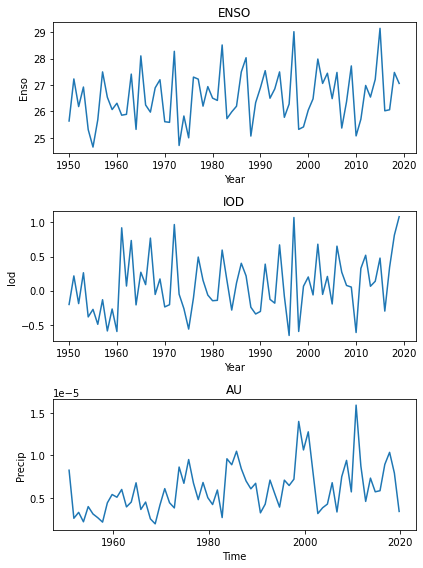

In [3]:
fig = plt.figure(figsize=(6,8)) 


plt.subplot(311)
qplt.plot(enso)
plt.title('ENSO')

plt.subplot(312)
qplt.plot(iod)
plt.title('IOD')

plt.subplot(313)
qplt.plot(au)
plt.title('AU')
plt.tight_layout()



## Step 2) Data Processing


### Standardize the data (zero mean, unit variance)


In [4]:
ENSO   = (enso - np.mean(enso.data))/np.std(enso.data)
AU     = (au - np.mean(au.data))/np.std(au.data)
IOD    = (iod - np.mean(iod.data))/np.std(iod.data)

### Detrend

In [5]:
ENSO   = signal.detrend(ENSO.data)
AU     = signal.detrend(AU.data)
IOD    = signal.detrend(IOD.data)

## Step 3) Data Analysis


### Load into pandas

In [6]:
DATA = np.stack((ENSO ,IOD, AU)).T

In [7]:
df = pd.DataFrame(data=DATA, columns=["ENSO", "IOD", "AU"])

In [8]:
df

,ENSO,IOD,AU
0,-0.568193,-0.244902,1.502270
1,1.031345,0.728928,-0.518547
2,-0.036566,-0.239032,-0.293785
3,0.700767,0.814033,-0.707653
4,-0.939703,-0.722722,-0.097123
...,...,...,...
65,2.304798,0.572842,-0.740667
66,-0.861372,-1.269278,0.331561
67,-0.831318,0.230555,0.812708
68,0.586349,1.329264,-0.069035


### Make categorical data

In [9]:
df['AU'] = pd.qcut(df['AU'], 2,labels = ['low', 'high'])
df['ENSO'] = pd.qcut(df['ENSO'], 3, labels = ['Nina', 'neut', 'Nino'])
df['IOD'] = pd.qcut(df['IOD'], 3, labels = ['neg', 'zero', 'pos'])

### show contigency table (absolute numbers)

In [10]:
pd.crosstab( df['AU'], [ df['IOD'], df['ENSO']], margins=True,  dropna = False)

IOD   neg           zero            pos           All
ENSO Nina neut Nino Nina neut Nino Nina neut Nino    
AU                                                   
low     2    6    0    2    4    5    0    3   13  35
high   10    6    0    8    3    1    2    1    4  35
All    12   12    0   10    7    6    2    4   17  70

### Table 1b: Conditional probabilities for IOD and ENSO phases, P(IOD, ENSO). The default probability is 1/9.

In [11]:
pd.crosstab( df['IOD'], [df['ENSO']], normalize = "all", margins = False)

ENSO,Nina,neut,Nino
IOD,,,
neg,0.171429,0.171429,0.000000
zero,0.142857,0.100000,0.085714
pos,0.028571,0.057143,0.242857


### Tabel 1a: Conditional probabilities for above-average AU. The default probability is 1/2

#### 1) Conditional probabilities for below-average AU, P(AU- | IOD, ENSO) and above-average AU, i.e. P(AU+ | IOD, ENSO). The default probability is 1/2. 

In [12]:
pd.crosstab( df['AU'], [df['ENSO'], df['IOD']], normalize = 'columns', dropna = False)

ENSO      Nina           neut                 Nino                    
IOD        neg zero  pos  neg      zero   pos  neg      zero       pos
AU                                                                    
low   0.166667  0.2  0.0  0.5  0.571429  0.75  0.0  0.833333  0.764706
high  0.833333  0.8  1.0  0.5  0.428571  0.25  0.0  0.166667  0.235294

#### 2)  marginal probability of ENSO (bottom of table 1a), i.e.  P(AU-|ENSO) and P(AU+|ENSO) respectively. 

In [13]:
pd.crosstab( df['AU'],df['ENSO'], margins=True, normalize = "columns")

ENSO,Nina,neut,Nino,All
AU,,,,
low,0.166667,0.565217,0.782609,0.5
high,0.833333,0.434783,0.217391,0.5


#### 3) marginal probability of IOD (right side of table 1a), i.e. P(AU-|IOD) and P(AU+|IOD) respectively. 

In [14]:
pd.crosstab( df['AU'],df['IOD'], margins=True, normalize = "columns")

IOD,neg,zero,pos,All
AU,,,,
low,0.333333,0.478261,0.695652,0.5
high,0.666667,0.521739,0.304348,0.5
